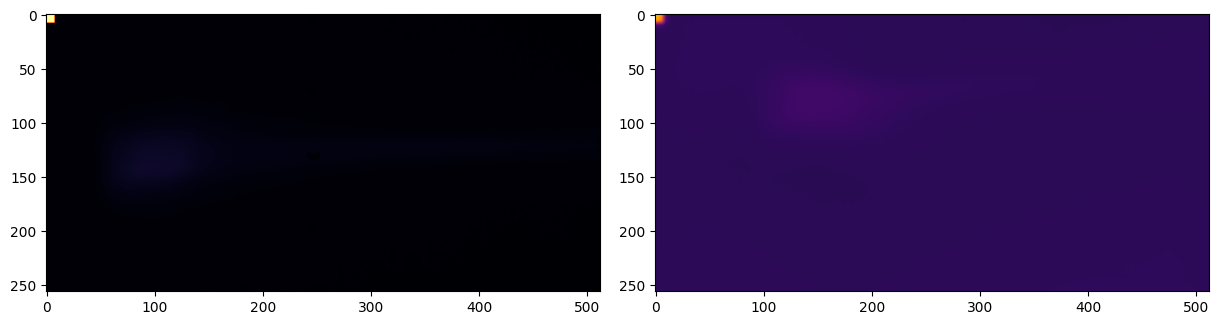

{'mse': tensor(6077.5381), 'mse_norm': tensor(0.0006), 'dtw_dist': 1594.645594982546, 'ssim': tensor(0.1608, dtype=torch.float64)}


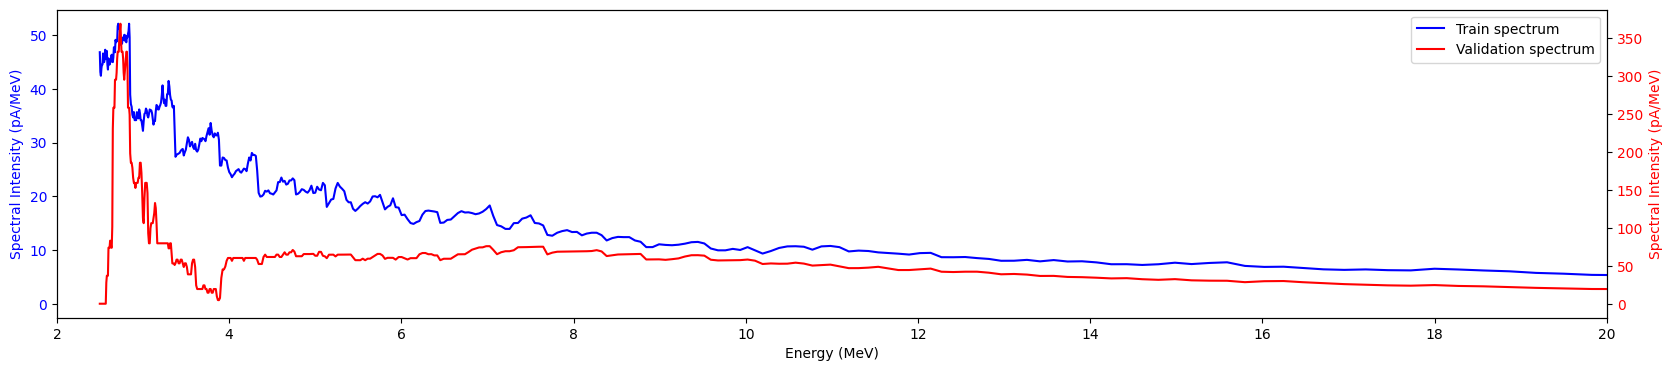

In [11]:
from metrics import *
import matplotlib.pyplot as plt
from src.utils import deflection_calc

def compare_avg_plot(im1, im2):
    fig, axs = plt.subplots(1, 2, figsize=(15, 4))
    fig.subplots_adjust(hspace=0.35)  # Increase the space between rows
    fig.subplots_adjust(wspace=0.1)  # Decrease the space between columns
    # im2 *= 3
    # im2[:10, :10] = 255
    axs[0].imshow(im1, vmin=0, vmax=255, cmap='inferno')
    axs[1].imshow(im2, vmin=0, vmax=255, cmap='inferno')
    plt.show()

def plot_spectra(sp1, sp2, el_pointing_pixel=62, xlim=[2, 20]):
    fig, ax1 = plt.subplots(figsize=(20, 4))
    deflection_MeV = deflection_calc(1, len(sp1), el_pointing_pixel).flatten()
    
    # Plot the first sequence on the left y-axis
    ax1.plot(deflection_MeV, sp1, label='Train spectrum', color='blue')
    ax1.set_ylabel('Spectral Intensity (pA/MeV)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_xlabel('Energy (MeV)')
    ax1.set_xlim(xlim)
    
    # Create a second y-axis on the right side
    ax2 = ax1.twinx()
    
    # Plot the second sequence on the right y-axis
    ax2.plot(deflection_MeV, sp2, label='Validation spectrum', color='red')
    ax2.set_ylabel('Spectral Intensity (pA/MeV)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    
    # Add a legend
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper right')
    
    plt.show()

# 3, 8, 11, 19, 21
dirnum = 19

dir1 = 'data/with_gain/' + str(dirnum)
# dir2 = 'results/valid_nophys_1000ns_sec25_cfg3/' + str(dirnum)
dir2 = 'results/valid_phys10th_850ns_sec1x9plus6_cfg5/' + str(dirnum)

res, spectra = compare_spectra(dir1, dir2, dirnum)
img1, img2 = compare_avg(dir1, dir2)
compare_avg_plot(img1, img2)
print(res)
plot_spectra(spectra['spectr_train'], spectra['spectr_valid'])